# Fake vs Real Face Classification

This notebook describes the dataset, shows how to mount Google Drive, verifies the dataset structure, visualizes sample images, and provides preprocessing + dataset-loading code ready for training.

>  (e.g. `/content/drive/MyDrive/AI_Project/Dataset/Faces_10percent_resized`).




## Project & Dataset Info

- **Project title:** Fake vs Real Face Images Classification
- **Dataset folder name (given):** `Faces_10percent_resized`
- **Expected structure (inside dataset folder):**

```
Train/
  ├── Real/
  └── Fake/
Test/
  ├── Real/
  └── Fake/
Val/
  ├── Real/
  └── Fake/
```

- **Description:** Binary classification dataset containing real and deepfake  face images.



In [2]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')



DATASET_PATH = '/content/drive/MyDrive/Faces_10percent_resized'
print('DATASET_PATH =', DATASET_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATASET_PATH = /content/drive/MyDrive/Faces_10percent_resized


In [3]:
# Verify the dataset structure and count images per split/class
import os

def count_images(path):
    counts = {}
    for root, dirs, files in os.walk(path):
        # ignore hidden files
        files = [f for f in files if not f.startswith('.')]
        if files:
            rel = os.path.relpath(root, path)
            counts[rel] = len(files)
    return counts

if not os.path.exists(DATASET_PATH):
    print('WARNING: DATASET_PATH does not exist. Update the path above and re-run the cell.')
else:
    print('Listing top-level directories in dataset folder:')
    for name in sorted(os.listdir(DATASET_PATH)):
        print('-', name)
    print('\nImage counts (by folder):')
    counts = count_images(DATASET_PATH)
    for k,v in sorted(counts.items()):
        print(f'{k}: {v} images')

Listing top-level directories in dataset folder:
- Test
- Train
- Val

Image counts (by folder):
Test/Fake: 549 images
Test/Real: 541 images
Train/Fake: 7000 images
Train/Real: 7000 images
Val/Fake: 1964 images
Val/Real: 1978 images


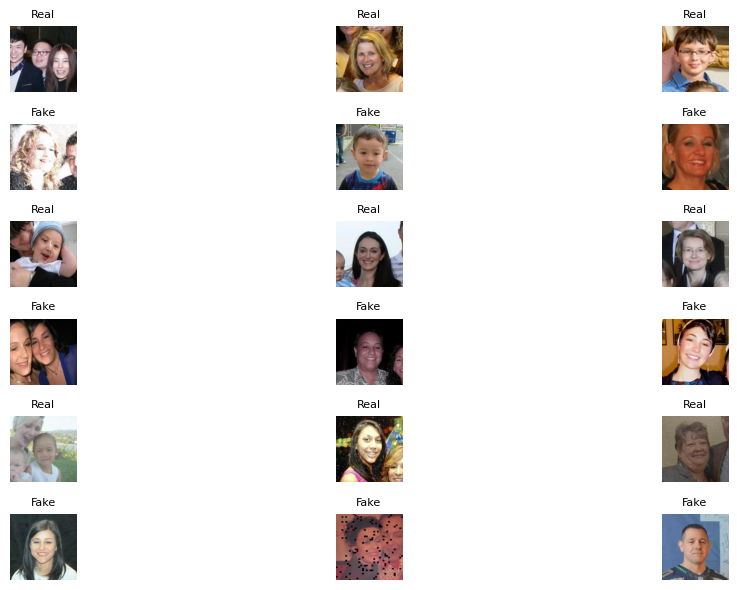

In [4]:
# Display sample images from each class
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

def show_examples(dataset_path, n_per_class=3, figsize=(12,6)):
    classes = ['Train/Real','Train/Fake','Val/Real','Val/Fake','Test/Real','Test/Fake']
    fig = plt.figure(figsize=figsize)
    plotted = 0
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        if os.path.exists(cls_path):
            imgs = [f for f in os.listdir(cls_path) if not f.startswith('.')]
            if not imgs:
                continue
            picks = random.sample(imgs, min(n_per_class, len(imgs)))
            for p in picks:
                plotted += 1
                ax = fig.add_subplot(len(classes), n_per_class, plotted)
                img = Image.open(os.path.join(cls_path, p)).convert('RGB')
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(cls.split('/')[-1], fontsize=8)
    plt.tight_layout()
    plt.show()

if os.path.exists(DATASET_PATH):
    show_examples(DATASET_PATH)
else:
    print('Dataset path not found. Please update DATASET_PATH and re-run.')

In [8]:
# Example: Create TensorFlow datasets (train/val/test) using image_dataset_from_directory
# This cell demonstrates a typical preprocessing pipeline (224x224 resizing, batching, normalization).
import tensorflow as tf
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def create_dataset(split_dir):
    path = os.path.join(DATASET_PATH, split_dir)
    if not os.path.exists(path):
        print('Missing path:', path)
        return None
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='binary',  # binary classification
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True
    )
    return ds

train_ds = create_dataset('Train')
val_ds = create_dataset('Val')
test_ds = create_dataset('Test')

# Prefetch for performance
if train_ds is not None:
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
if val_ds is not None:
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print('Datasets created. Examples:')
print('Train batches:', None if train_ds is None else len(list(train_ds.take(1))[0][0]))

Found 14000 files belonging to 2 classes.
Found 3942 files belonging to 2 classes.
Found 1090 files belonging to 2 classes.
Datasets created. Examples:
Train batches: 32


In [9]:
# Preprocessing and simple augmentation example
from tensorflow.keras import layers, models

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.02),
])

# Normalization layer (rescale 0-1)
normalization_layer = layers.Rescaling(1./255)

# Example model head (transfer learning recommended)
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(224,224,3), pooling='avg')
base_model.trainable = False  # freeze base for transfer learning

inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = normalization_layer(x)
x = base_model(x, training=False)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:

# Example: training then saving model
# model.fit(train_ds, validation_data=val_ds, epochs=5)
# After training, save the model to Drive so you can reload it later
MODEL_SAVE_PATH = '/content/drive/MyDrive/AI_Project/models/fake_face_detector'
# os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
# model.save(MODEL_SAVE_PATH)